# Visualizing cross-validation methods

Descriptions and visualizations for the cross-validation methods implemented in [`splitters.py`](splitters.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import preprocessing
import splitters

sns.set_theme(style="whitegrid")

In [2]:
X_train, y_train = preprocessing.read_tsv_with_all_features("../../data/tournament_dataset/train.tsv")

In [3]:
# Select 50 samples for the main visualizations
rng = np.random.default_rng(seed=27)
idx = rng.choice(np.arange(len(X_train)), size=50, replace=False)
X_sample, y_sample = X_train.iloc[idx], y_train.iloc[idx]

In [4]:
def visualize_splitter(splitter: splitters.Splitter, vlines: np.ndarray | None = None):
    splits = list(splitter.split(X_sample, y_sample))
    order = y_sample.argsort()

    fig, axs = plt.subplots(nrows=min(5, len(splits)), sharex=True, figsize=(12, 8))
    for i, (split, ax) in enumerate(zip(splits, axs)):
        hue = np.where(split.val_idx, "val", "train")
        sns.barplot(x=range(len(y_sample)), y=np.log(y_sample.iloc[order]), hue=hue[order], hue_order=["train", "val"], ax=ax)

        ax.xaxis.set_visible(False)
        ax.set_xlim((-0.5, 49.5))
        ax.set_ylabel("target")
        ax.set_yticks([])
        ax.tick_params(axis="y", which="both", labelbottom=False)
        ax.legend(title=f"split {i + 1}", bbox_to_anchor=(1, 1))

        if vlines is not None:
            ymin, ymax = ax.get_ylim()
            for x in vlines:
                ax.vlines(x=x, ymin=ymin, ymax=ymax, color="gray")

    axs[0].set_title(f"{type(splitter).__name__} visualization{" (first 5 splits)" if len(splits) > 5 else ""}")

In [5]:
def compare_fold_distributions(
    splitter1: splitters.Splitter, splitter2: splitters.Splitter, X: pd.DataFrame, y: pd.DataFrame
):
    folds = []
    for splitter in [splitter1, splitter2]:
        splits = list(splitter.split(X, y))
        fold = np.empty(len(y), dtype=int)
        for j, split in enumerate(splits):
            fold[split.val_idx] = j
        folds.append(fold)

    y_long = np.tile(y, 2)
    fold_long = np.concat([folds[0], folds[1]])
    splitter_idx_long = (np.arange(2 * len(y)) >= len(y)).astype(int)

    grid = sns.displot(
        x=np.log(y_long), row=fold_long, col=splitter_idx_long,
        bins=np.linspace(2, 8, 40),
        facet_kws={"despine": False}
    )
    grid.figure.set_size_inches(12, 5)

    for (row, col), ax in grid.axes_dict.items():
        if row == 0:
            name = type([splitter1, splitter2][col]).__name__
            ax.set_title(f"Distribution of the target variable in folds\ncreated by {name} ({len(y)} samples)")
        else:
            ax.set_title("")
        ax.yaxis.set_visible(False)
        ax.set_xlabel("target variable")

        ax.annotate(
            f"fold {row + 1}",
            xy=(0.885, 0.58),
            xycoords="axes fraction",
            size=14,
            bbox=dict(boxstyle="round", fc="white", ec=".8")
        )

    plt.tight_layout()

## Definitions

Let $S = \{s_1, s_2, \ldots, s_n\}$ be the dataset used for the cross-validation. Each sample $s_i$ can be represented as a tuple $(x_i, y_i)$, where $x_i$ is the feature vector and $y_i$ is the value of the target variable.

Let $Q(S_t, S_v)$ be the quality of the model trained on $S_t \subset S$ and evaluated on $S_v \subset S$. This can be any metric, such as the $R^2$ score for a regression problem.

## K-fold

This method splits the data into $k$ equal subsets ("folds"), then produces $k$ splits where the $i$-th split uses the $i$-th fold as the validation set and the other $k-1$ folds as the training set.

Let $F_1, F_2, \ldots, F_k$ denote the folds. They are selected randomly such that:
- $\bigcup_{i = 1}^k F_i = S$
- $\forall i, j, i \neq j \quad F_i \cap F_j = \emptyset$
- $|F_1| = \ldots = |F_k| = \frac{|S|}{k}$ if that is a whole number, or as close as possible if it is not.

The overall quality is then computed as

$$
Q_\mathrm{k-fold} = \frac{1}{k} \sum_{i = 1}^k Q \left( S \setminus F_i, F_i \right)
$$

Below is a visualization of a 50-sample dataset being split with this method. The height of each bar corresponds to the value of the target variable for that sample (in my case, the logarithm of the number of players attending the tournament).

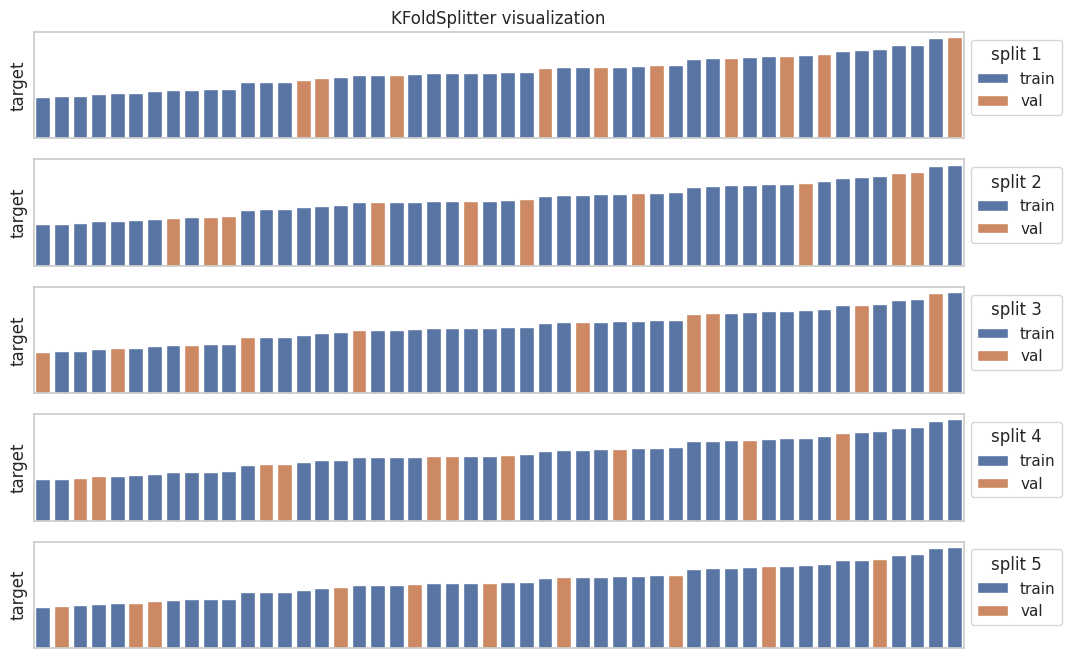

In [6]:
visualize_splitter(splitters.KFoldSplitter(k=5, random_state=27))

## Stratified k-fold (adapted for a continuous target variable)

This modification of the k-fold method is normally used for classification tasks, but I have implemented an adaptation of it for regression. The goal is to make the target variable distributions in the folds as similar as possible.

The dataset is sorted in descending order of the value of the target variable. Then, the samples are split into blocks of consecutive samples, $k$ samples each. In each block, each of the $k$ samples is randomly put into one of the $k$ folds, one sample in each fold.

Formally, for each block, a random permutation $(p_1, \ldots, p_k)$ of the numbers $1$ to $k$ is generated. Then, the $j$-th sample in the block is assigned to the fold $F_{p_j}$. If the last block has less than $k$ samples, some folds will end up with one sample more than others.

As in the regular k-fold algorithm, the following holds for the resulting folds $F_1, \ldots, F_k$:
- $\bigcup_{i = 1}^k F_i = S$
- $\forall i, j, i \neq j \quad F_i \cap F_j = \emptyset$
- $|F_1| = \ldots = |F_k| = \frac{|S|}{k}$ if that is a whole number, or as close as possible if it is not.

The overall quality is then computed as

$$
Q_\mathrm{k-fold} = \frac{1}{k} \sum_{i = 1}^k Q \left( S \setminus F_i, F_i \right)
$$

In the visualization below, the $k$-sample blocks are separated by gray lines. The samples within each block are all assigned to different folds.

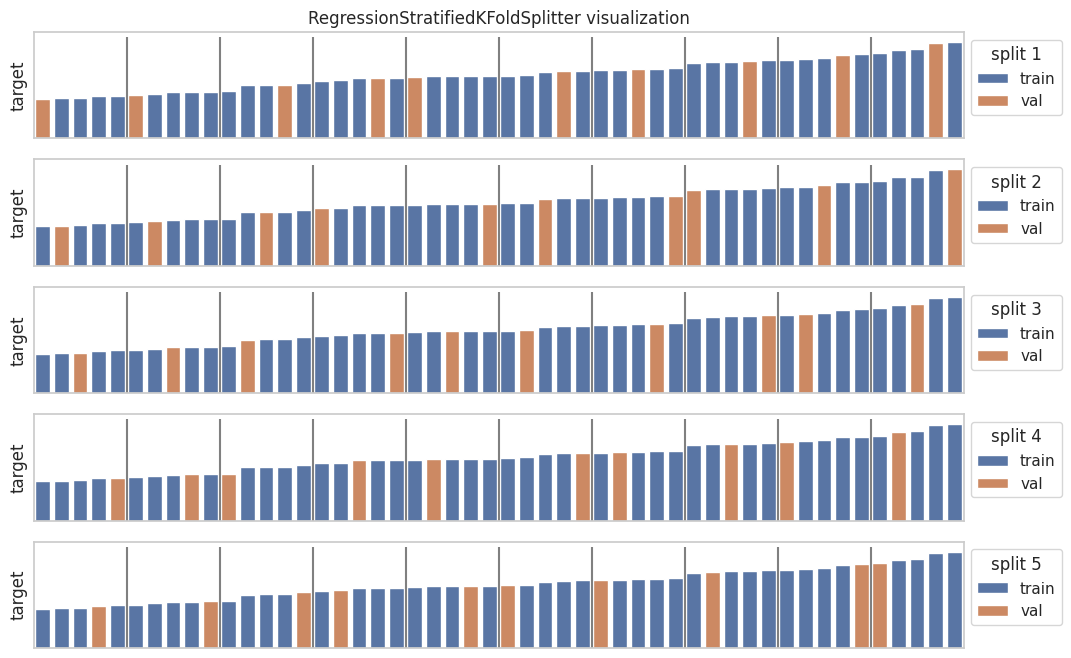

In [7]:
visualize_splitter(splitters.RegressionStratifiedKFoldSplitter(k=5, random_state=27), vlines=np.arange(5, 50, 5) - 0.5)

To see the difference between this method and standard k-fold, let's consider a dataset of 1000 samples and compare the distributions of the target variable on the resulting folds.

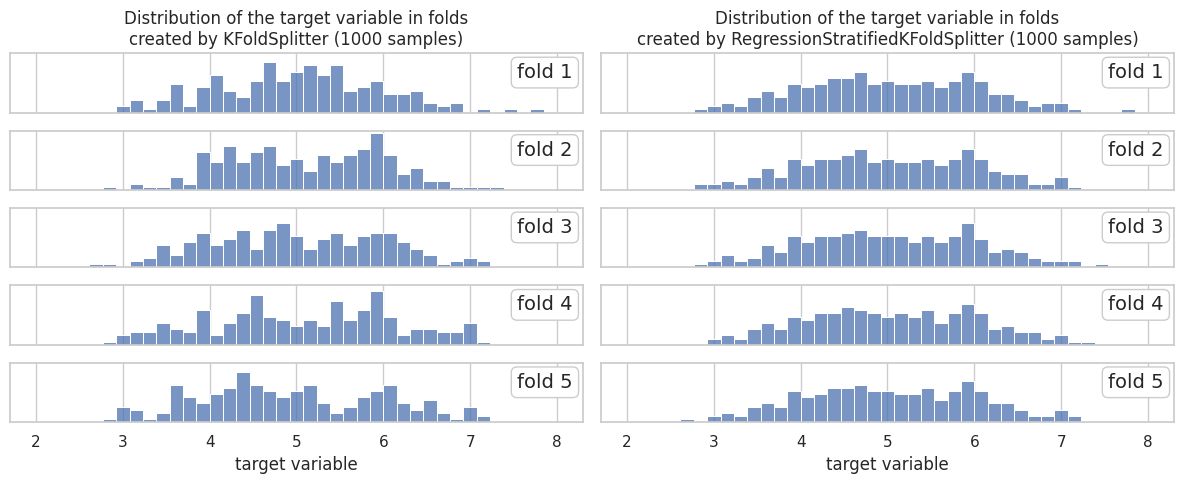

In [8]:
rng = np.random.default_rng(seed=27)
idx = rng.choice(np.arange(len(X_train)), size=1000, replace=False)
X_sample_big, y_sample_big = X_train.iloc[idx], y_train.iloc[idx]

compare_fold_distributions(
    splitters.KFoldSplitter(k=5, random_state=27),
    splitters.RegressionStratifiedKFoldSplitter(k=5, random_state=27),
    X_sample_big, y_sample_big
)

The graphs show that the distributions in the folds created by vanilla k-fold can be fairly different, whereas with stratified k-fold they are very similar.

However, on the entire dataset (over 200,000 samples) the distinction is essentially invisible:

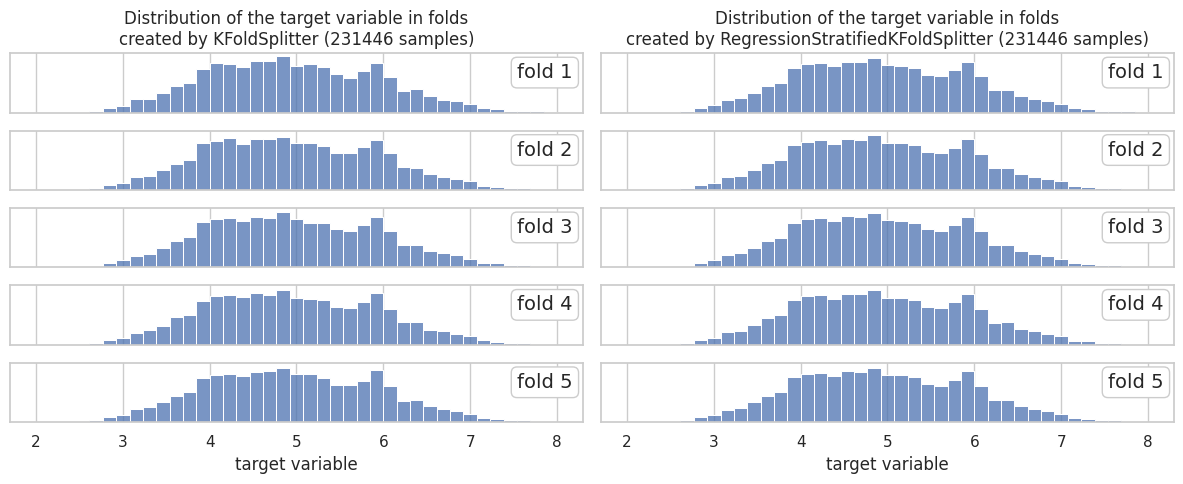

In [9]:
compare_fold_distributions(
    splitters.KFoldSplitter(k=5, random_state=27),
    splitters.RegressionStratifiedKFoldSplitter(k=5, random_state=27),
    X_train, y_train
)

This suggests that as the dataset size increases, even purely randomly selected folds will tend to the same distribution, rendering stratification less necessary.

## Monte Carlo

This method produces $k$ splits. For the $i$-th split, a validation set $V_i$ is selected randomly independently of the other splits, and the other $S \setminus V_i$ samples make up the training set. The size of the validation set $|V_i| = p \cdot |S|$, where $p \in (0, 1)$ is a parameter set in advance.

This method is different from k-fold in that each sample is not guaranteed to be validated on exactly once. Many samples will be in the validation set in multiple splits, or in none at all. However, in this method the number of splits $k$ and the size of the validation set $p$ are set independently. This means that with a small validation set size, the user is free to do less splits than k-fold would allow, trading off some accuracy for performance.

The quality is computed similarly to the previous two methods:

$$
Q_\mathrm{MC} = \frac{1}{k} \sum_{i = 1}^k Q \left( S \setminus V_i, V_i \right)
$$

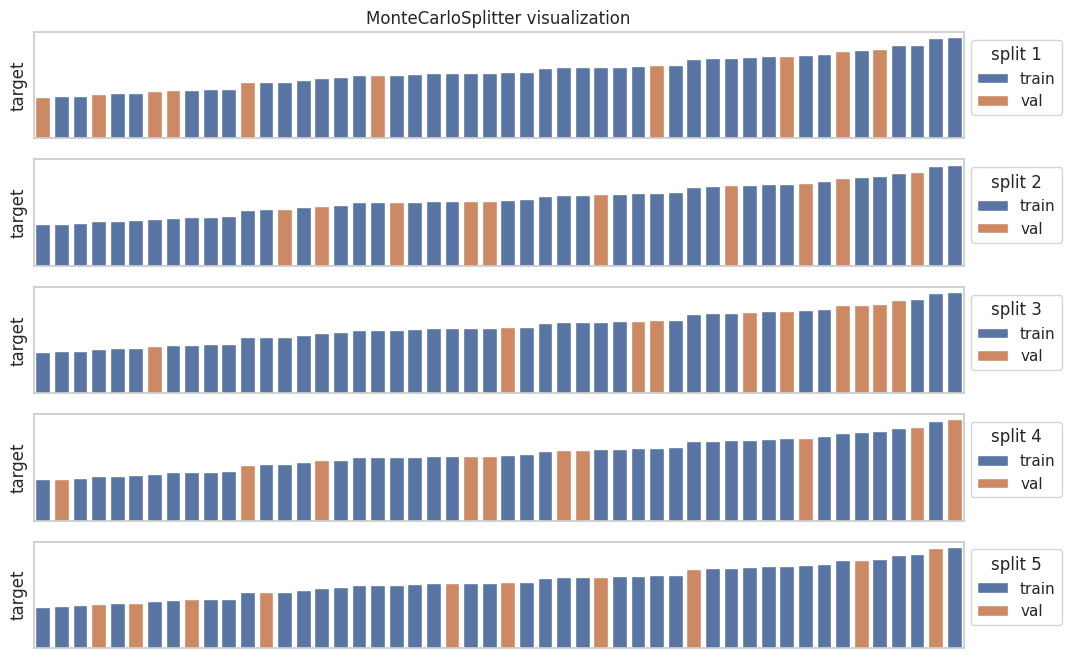

In [10]:
visualize_splitter(splitters.MonteCarloSplitter(n_splits=5, val_size=0.2, random_state=27))

## Leave-one-out

This method iterates over the dataset and for each sample $s_i$ trains a model on all the other samples $S \setminus \{s_i\}$ and validates it on just $s_i$. This is theoretically the most accurate method, and the only deterministic method of the ones considered in this notebook. However, in most cases it is computationally infeasible, as it requires training $|S|$ models.

The leave-one-out quality is computed as follows:

$$
Q_\mathrm{LOO} = \frac{1}{|S|} \sum_{i = 1}^{|S|} Q \left( S \setminus \{s_i\}, \{s_i\} \right)
$$

The visualization below only shows the first 5 splits for brevity.

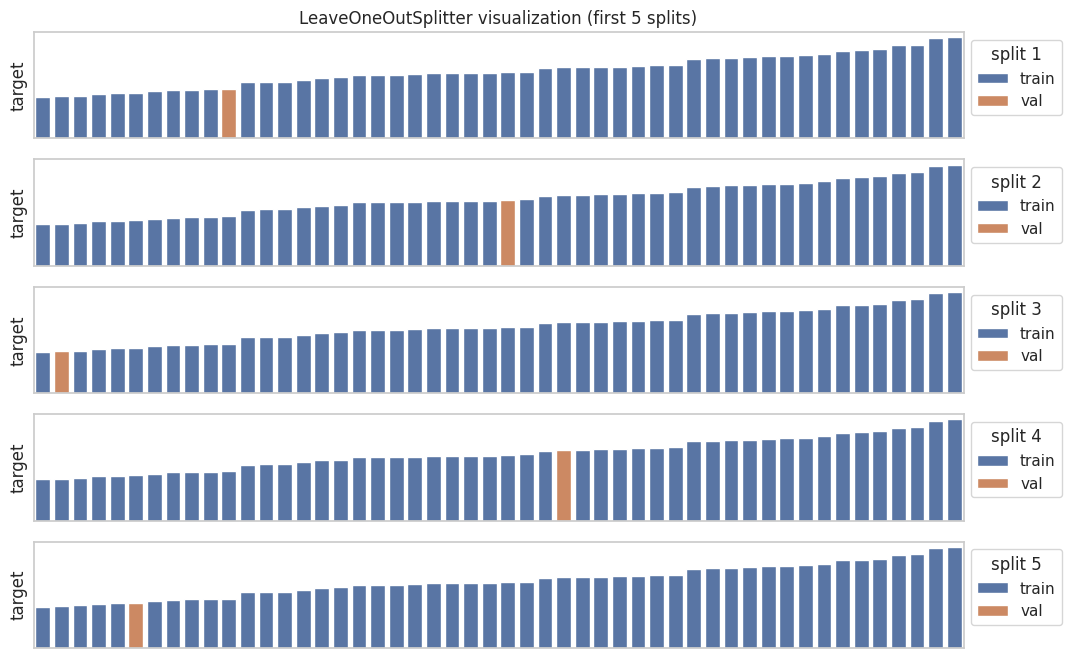

In [11]:
visualize_splitter(splitters.LeaveOneOutSplitter())